In [2]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
#import esmlab
import utils
import pandas as pd
import numpy as np
import cmocean

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/FEISTY'

files = sorted(glob(f'{path}/FEISTY-hi-res-x0.1-????.nc'))
        
ds=xr.open_mfdataset(files,concat_dim="time", coords='minimal', compat="override", combine='nested')

In [4]:
ds['time'] = np.arange(1980,2022)

### Spin up a Dask cluster

In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='06:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(24) 

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33681/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33681/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.88:38247,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33681/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Make a mean over the whole FEISTY simulation

In [8]:
ds = ds.mean(dim='time').compute()

### Sum up yields for each fish type

In [9]:
forage_fish_yield = ds.fish_yield.sel(fish='Sf') + ds.fish_yield.sel(fish='Mf')

In [10]:
demersal_fish_yield = ds.fish_yield.sel(fish='Sd') + ds.fish_yield.sel(fish='Md') + ds.fish_yield.sel(fish='Ld')

In [11]:
pelagic_fish_yield = ds.fish_yield.sel(fish='Sp') + ds.fish_yield.sel(fish='Mp') + ds.fish_yield.sel(fish='Lp')

In [12]:
total_fish_yield = forage_fish_yield + demersal_fish_yield + pelagic_fish_yield

### Get grid info

In [13]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

### Get LME shapefile

In [14]:
import shapefile as shp
sf = shp.Reader("/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LMEs66_Offshore")

## Mean fish yield maps

### No vmin/vmax

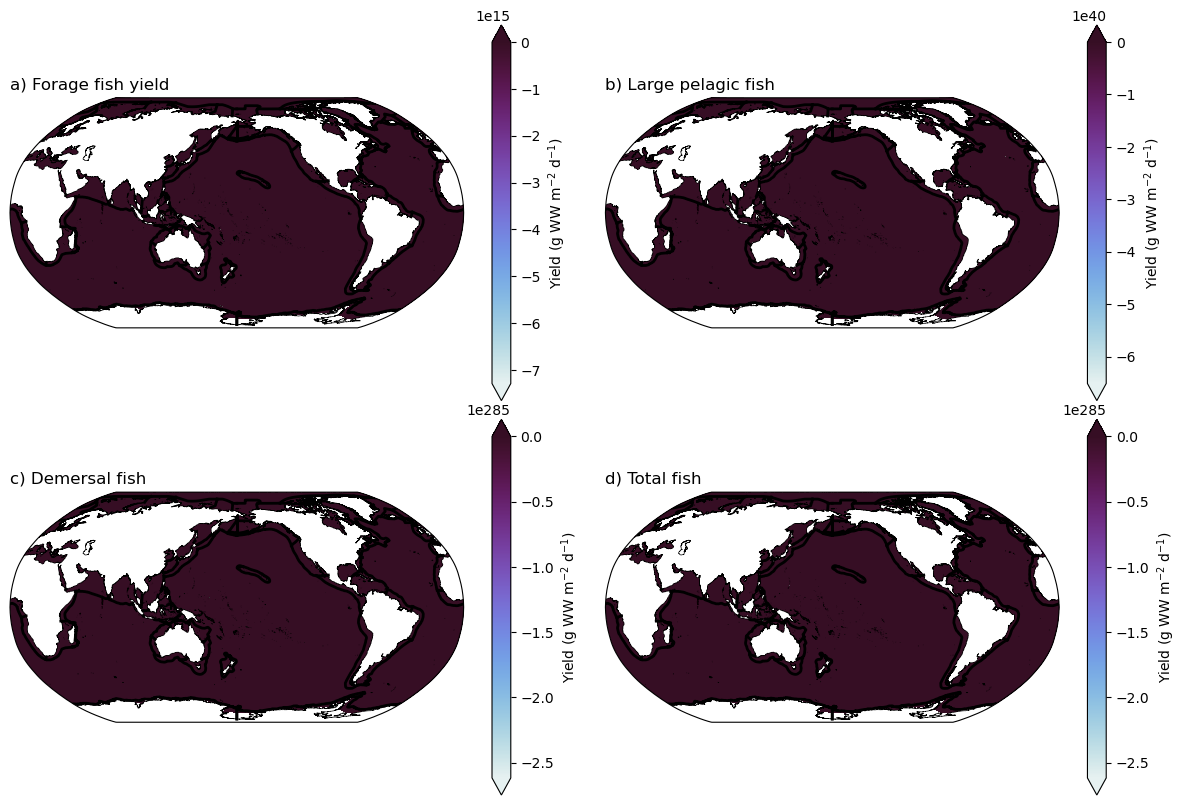

In [15]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Put vmin=0, vmax=0.05

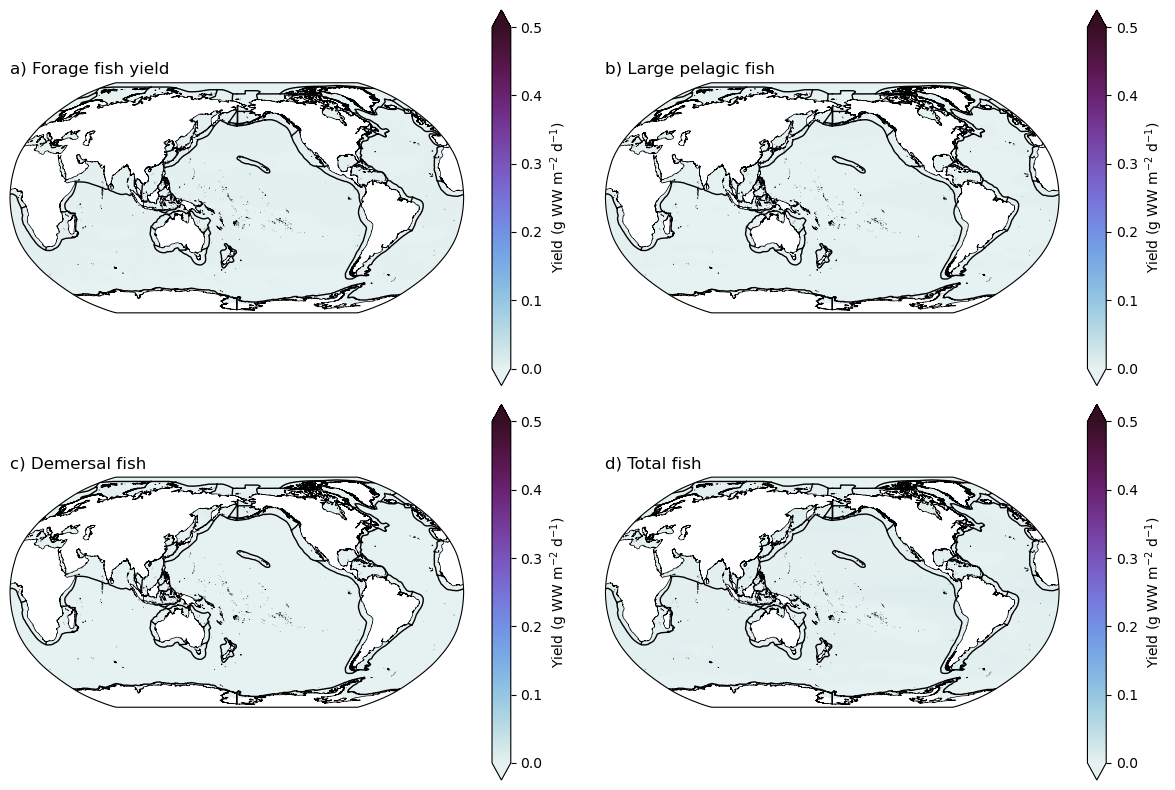

In [16]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Put vmin=0, vmax=0.1

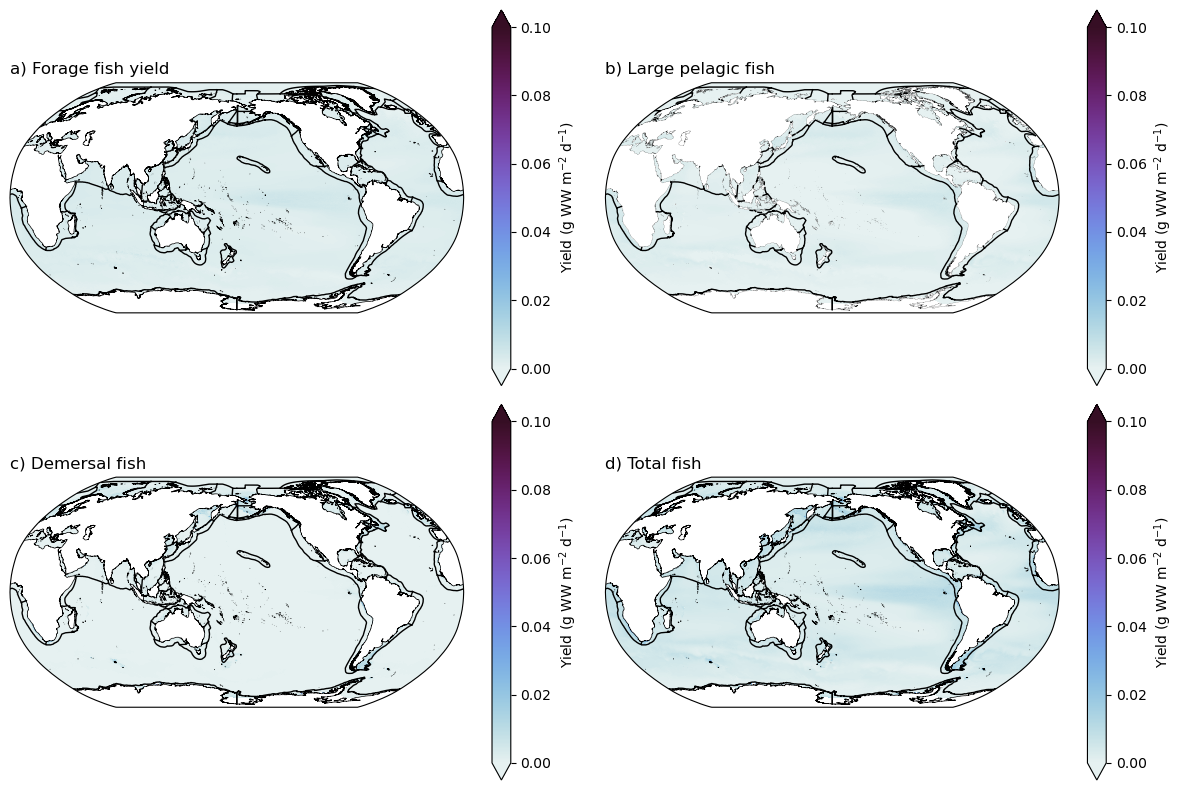

In [17]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.1, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.1, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.1)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.1, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.1, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Put vmin=0, vmax=0.05

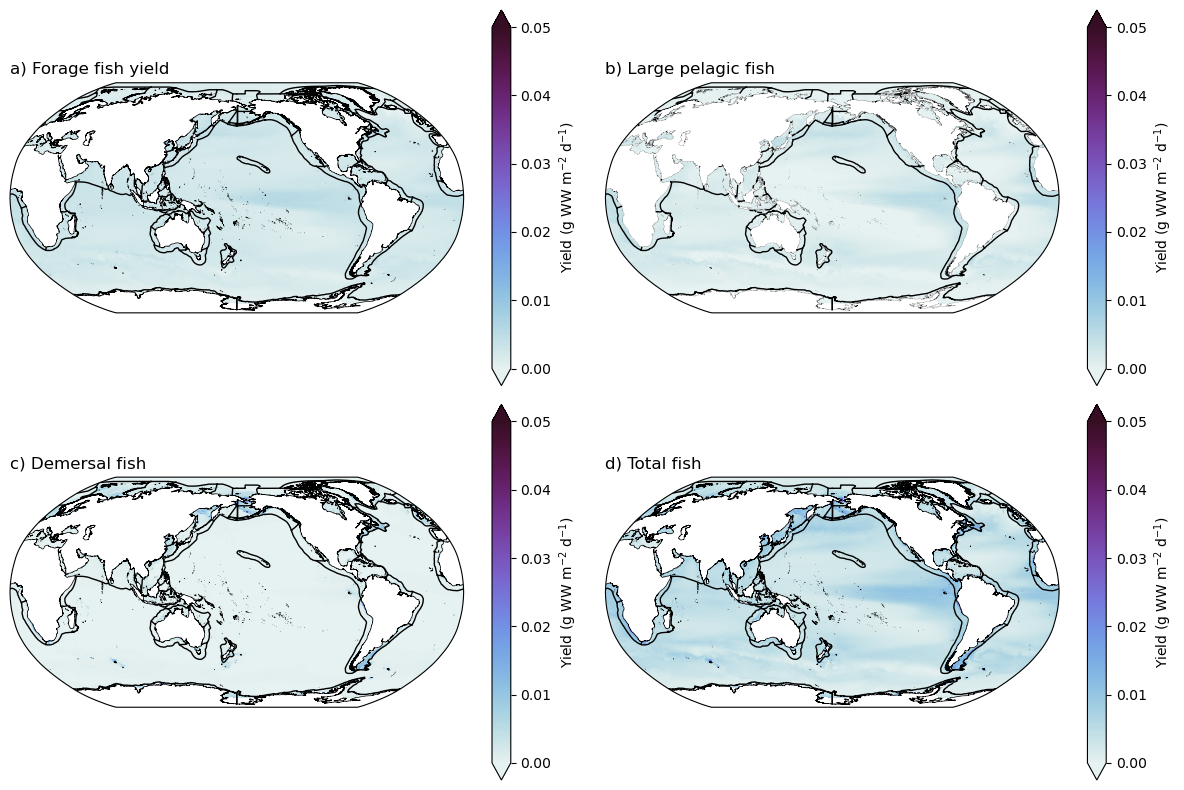

In [18]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.05, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.05, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.1)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.05, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.05, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

### put vmin=0, vmax=0.01.... and we finally see the fish yield distributions

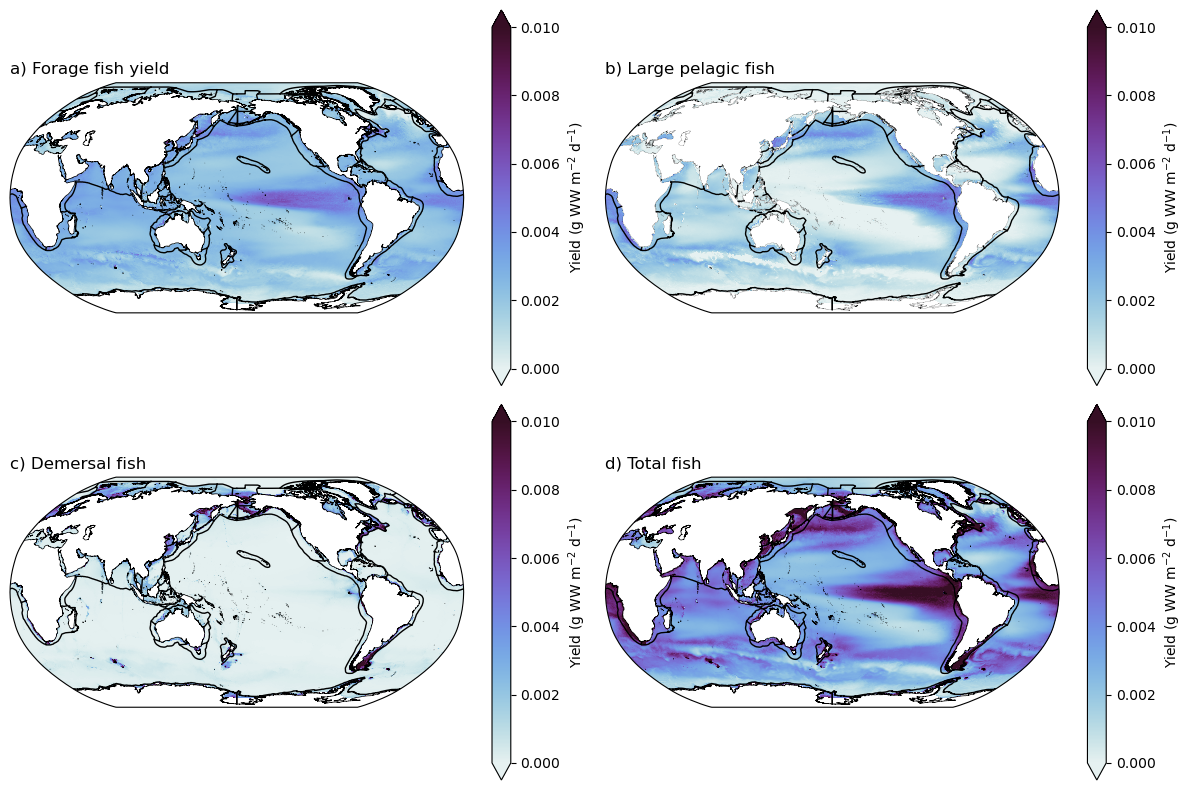

In [19]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.01, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.01, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.1)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.01, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.01, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=1);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Try putting the max fish yield at 0.5 and replot without putting vmin/vmax values

In [22]:
forage_fish_yield2 = forage_fish_yield.where(forage_fish_yield<0.5).compute()
demersal_fish_yield2 = demersal_fish_yield.where(demersal_fish_yield<0.5).compute()
pelagic_fish_yield2 = pelagic_fish_yield.where(pelagic_fish_yield<0.5).compute()
total_fish_yield2 = total_fish_yield.where(total_fish_yield<0.5).compute()

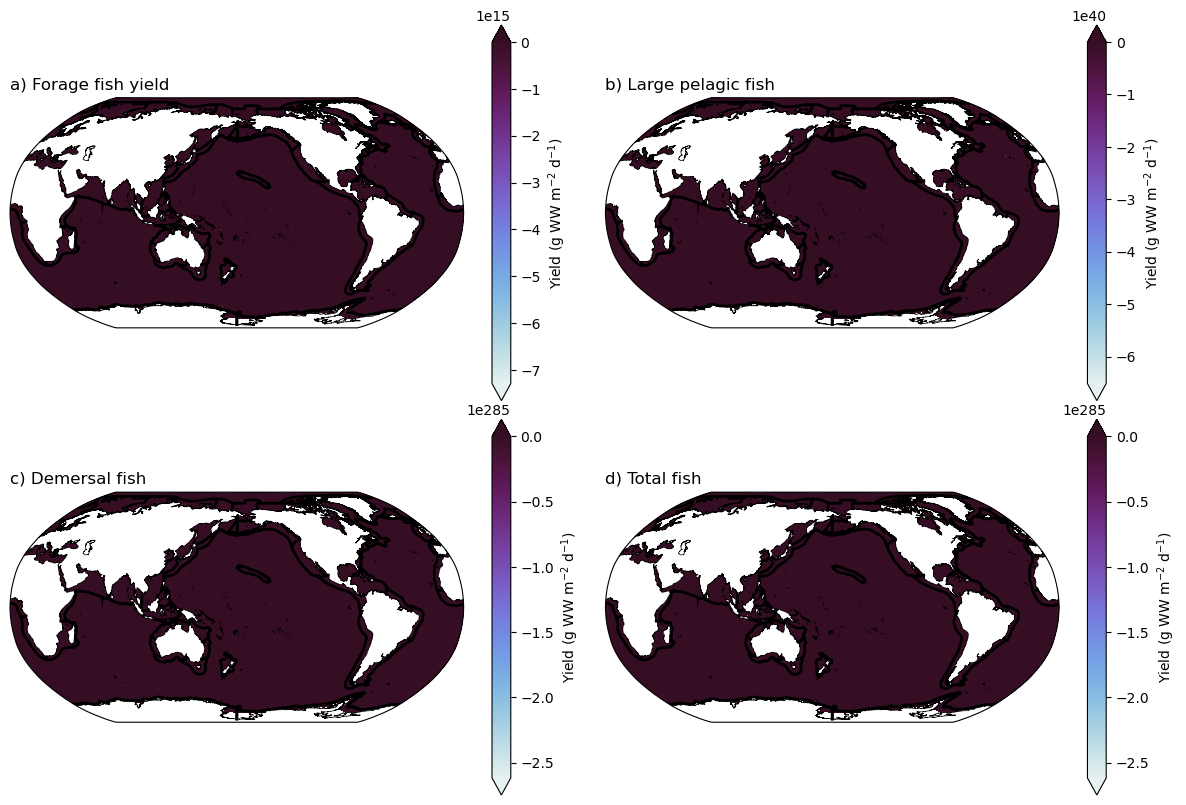

In [23]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield2) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield2) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield2) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield2) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [27]:
forage_fish_yield = forage_fish_yield.where(forage_fish_yield<0.5,other=0.5).where(ds_grid.REGION_MASK>0).compute()
demersal_fish_yield = demersal_fish_yield.where(demersal_fish_yield<0.5,other=0.5).where(ds_grid.REGION_MASK>0).compute()
pelagic_fish_yield = pelagic_fish_yield.where(pelagic_fish_yield<0.5,other=0.5).where(ds_grid.REGION_MASK>0).compute()
total_fish_yield = total_fish_yield.where(total_fish_yield<0.5,other=0.5).where(ds_grid.REGION_MASK>0).compute()

In [30]:
np.max(forage_fish_yield)

<xarray.DataArray 'fish_yield' ()>
array(0.5)

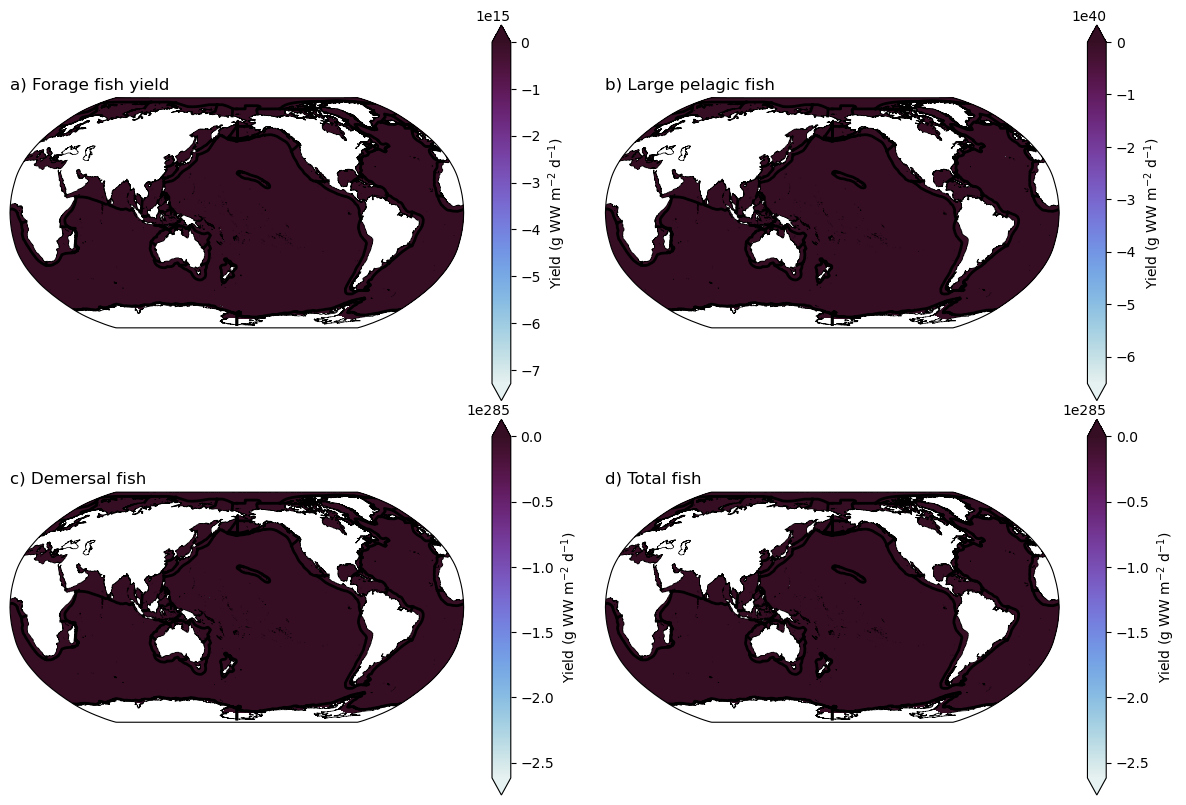

In [28]:
fig = plt.figure(figsize=(15,10))


####################### fish

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Forage fish yield', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, forage_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, pelagic_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


###########
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, demersal_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')

#########
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, total_fish_yield) 

pc=ax.pcolormesh(lon, lat, field, 
                 #vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='k',linewidth=2);
ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Yield (g WW m$^{-2}$ d$^{-1}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)